In [1]:
import numpy as np
import pandas as pd
from fastai.vision.all import show_image

from ipywidgets import interact
import ipywidgets as widgets

import mediapipe as mp
from mediapipe.framework.formats import landmark_pb2

from average_parquet import Averager

mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_holistic = mp.solutions.holistic

c:\Users\zorko\anaconda3\envs\IS460MLApps\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [8]:
def draw_landmarks(landmarks,image,show_pose=True,show_face_contour=False,show_face_tesselation=False,show_left_hand=True,show_right_hand=True):
    annotated_image = image.copy()
    results = landmarks
    if show_face_tesselation:
        mp_drawing.draw_landmarks(
            annotated_image,
            results.face_landmarks,
            mp_holistic.FACEMESH_TESSELATION,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp_drawing_styles
            .get_default_face_mesh_tesselation_style())
    if show_face_contour:
        mp_drawing.draw_landmarks(
            annotated_image,
            results.face_landmarks,
            mp_holistic.FACEMESH_CONTOURS,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp_drawing_styles
            .get_default_face_mesh_contours_style())
    if show_pose:
        mp_drawing.draw_landmarks(
            annotated_image,
            results.pose_landmarks,
            mp_holistic.POSE_CONNECTIONS,
            landmark_drawing_spec=mp_drawing_styles.
            get_default_pose_landmarks_style())
    if show_left_hand:
        mp_drawing.draw_landmarks(
            annotated_image,
            results.left_hand_landmarks,
            mp_holistic.HAND_CONNECTIONS,
            landmark_drawing_spec=mp_drawing_styles
            .get_default_hand_landmarks_style())
    if show_right_hand:
        mp_drawing.draw_landmarks(
            annotated_image,
            results.right_hand_landmarks,
            mp_holistic.HAND_CONNECTIONS,
            landmark_drawing_spec=mp_drawing_styles
            .get_default_hand_landmarks_style())
    return annotated_image

In [3]:
from os import listdir
from os.path import isfile, join


folder = "orange/"
path = "./asl-kaggle/by_labels/"+folder
save_path = "./asl-kaggle/averaged_by_labels/"+folder
parquets = [f for f in listdir(path) if isfile(join(path, f))]

In [4]:
len(parquets)

390

In [5]:
# parquets[234:]

In [6]:
for parquet in parquets:
    parquet_path = path+parquet
    pf = pd.read_parquet(parquet_path)

    avgr = Averager(pf)
    new_pf = avgr.average_pf()

    new_pf.to_parquet(save_path+parquet)

In [60]:
path = "./asl-kaggle/by_labels/orange/3390063927.parquet"
pf = pd.read_parquet(path)
pf.head()

,frame,row_id,type,landmark_index,x,y,z
0,14,14-face-0,face,0,0.480925,0.520614,-0.039797
1,14,14-face-1,face,1,0.471885,0.486111,-0.057065
2,14,14-face-2,face,2,0.476459,0.498150,-0.034013
3,14,14-face-3,face,3,0.463271,0.460442,-0.034678
4,14,14-face-4,face,4,0.470690,0.477398,-0.058757


In [20]:
points_types = pf['type'].unique()
points_types_lens = {}
cnt_frames = max(pf['frame']) - min(pf['frame'])

pf = pf.fillna(-1)

for point_type in points_types:
    frames_for_type = len(pf['frame'].loc[(pf.type==point_type) & (pf.x > 0)].unique())
    if frames_for_type < int(cnt_frames/10):
        pf.loc[pf['type']==point_type, 'x'] = np.nan
        pf.loc[pf['type']==point_type, 'y'] = np.nan
        pf.loc[pf['type']==point_type, 'z'] = np.nan

In [21]:
# pf = pf.fillna(-1)
nas_indexes = list(pf.loc[pf['x'] < 0].index)
len(nas_indexes)

126

In [22]:
nas_dict = {}

for idx in nas_indexes:
    row = pf.iloc[idx]

    frame = row.frame
    pt_type = row.type
    ldmrk_index = row.landmark_index

    if frame in nas_dict.keys():
        if pt_type in nas_dict[frame].keys():
            nas_dict[frame][pt_type].append(ldmrk_index)
        else:
            nas_dict[frame][pt_type] = [ldmrk_index]
    else:
        nas_dict[frame] = {pt_type: [ldmrk_index]}

In [53]:
next_positions_dict = {}
for point_type in points_types:
    next_positions_dict[point_type] = {"x": [], "y": [], "z": [], "frame": 0}

In [54]:
def fetch_coords(frame, point_type, pf):
    step_pf = pf.loc[(pf['frame']==frame) & (pf['type']==point_type)]
    x, y, z = step_pf['x'], step_pf['y'], step_pf['z']
    return x.values,y.values,z.values

In [55]:
import time
start = time.time()

max_frame = max(pf.frame)
min_frame = min(pf.frame)

for frame in nas_dict.keys():
    for pt_type in nas_dict[frame].keys():
        lndmrks_pos = nas_dict[frame][pt_type]

        if next_positions_dict[pt_type]['frame'] <= frame:
            step = 1
            while 1:
                if frame+step <= max_frame:
                    next_x, next_y, next_z = fetch_coords(frame+step, pt_type, pf)
                else:
                    if frame == min_frame:
                        next_x = next_y = next_z = [-1 for i in range(max(pf['landmark_index'].loc[pf.type==pt_type])+1)]
                    else:
                        next_x = pd.Series([]).values
                        j_step = 1
                        while next_x.size == 0:
                            next_x, next_y, next_z = fetch_coords(frame-j_step, pt_type, pf)
                            j_step += 1

                    next_positions_dict[pt_type]["x"] = next_x
                    next_positions_dict[pt_type]["y"] = next_y
                    next_positions_dict[pt_type]["z"] = next_z
                    next_positions_dict[pt_type]["frame"] = max_frame
                    break

                if (next_x < 0).all() or next_x.size == 0:
                    step += 1
                else:
                    next_positions_dict[pt_type]["x"] = next_x
                    next_positions_dict[pt_type]["y"] = next_y
                    next_positions_dict[pt_type]["z"] = next_z
                    next_positions_dict[pt_type]["frame"] = frame+step
                    break
        else:
            next_x = next_positions_dict[pt_type]["x"]
            next_y = next_positions_dict[pt_type]["y"]
            next_z = next_positions_dict[pt_type]["z"]
        
        if frame == min_frame:
            new_x = next_positions_dict[pt_type]["x"]
            new_y = next_positions_dict[pt_type]["y"]
            new_z = next_positions_dict[pt_type]["z"]
        else:
            prev_x = pd.Series([]).values

            i_step = 1
            while prev_x.size == 0:
                prev_x, prev_y, prev_z = fetch_coords(frame-i_step, pt_type, pf)
                i_step += 1

            frame_diff = (next_positions_dict[pt_type]["frame"] - frame) + 1

            new_x = prev_x + (next_x - prev_x)/frame_diff
            new_y = prev_y + (next_y - prev_y)/frame_diff
            new_z = prev_z + (next_z - prev_z)/frame_diff

        pf.loc[(pf.frame == frame) & (pf.type == pt_type) & (pf.landmark_index.isin(nas_dict[frame][pt_type])), 'x'] = [new_x[i] for i in lndmrks_pos]
        pf.loc[(pf.frame == frame) & (pf.type == pt_type) & (pf.landmark_index.isin(nas_dict[frame][pt_type])), 'y'] = [new_y[i] for i in lndmrks_pos]
        pf.loc[(pf.frame == frame) & (pf.type == pt_type) & (pf.landmark_index.isin(nas_dict[frame][pt_type])), 'z'] = [new_z[i] for i in lndmrks_pos]

end = time.time()
print(end-start)


0.08556842803955078


In [51]:
step

16

In [37]:
pf['frame'].loc[pf.type=="left_hand"].unique()

array([14, 15, 30, 31, 32], dtype=int16)

In [26]:
prev_x

array([], dtype=float64)

In [27]:
next_x

array([0.76933104, 0.70111138, 0.66704696, 0.64460373, 0.62384635,
       0.69187999, 0.65423709, 0.61527538, 0.5912298 , 0.70276612,
       0.65711647, 0.61764938, 0.59572554, 0.70827359, 0.66723889,
       0.62784088, 0.60542893, 0.70814073, 0.67618811, 0.64423239,
       0.62009048])

In [18]:
next_positions_dict

{'face': {'x': [], 'y': [], 'z': [], 'frame': 0},
 'left_hand': {'x': [], 'y': [], 'z': [], 'frame': 0},
 'pose': {'x': [], 'y': [], 'z': [], 'frame': 0},
 'right_hand': {'x': [], 'y': [], 'z': [], 'frame': 0}}

In [ ]:
# import time
# start = time.time()

# n_index = 0

# while n_index < len(nas_indexes):
#     index = nas_indexes[n_index]

#     frame = pf['frame'].iloc[index]
#     point_type = pf['type'].iloc[index]
#     type_len = points_types_lens[point_type]

#     count_steps = 0
#     # next_x = pd.Series([np.nan]).values
#     next_x = pd.Series([-1]).values

#     # while np.isnan(next_x).any():
#     while (next_x < 0).any() or next_x.size == 0:
#         if frame+count_steps <= max_frame:
#             next_x, next_y, next_z = step_fetch_coord(1, frame+count_steps, point_type, pf)
#             count_steps += 1
#         else:
#             next_x, next_y, next_z = step_fetch_coord(-1, frame, point_type, pf)
#             count_steps = 0
#             break

#     if frame != min_frame:
#         prev_x, prev_y, prev_z = step_fetch_coord(-1, frame, point_type, pf)

#         denominator = 2 + (count_steps)*0.5
#         new_x, new_y, new_z = prev_x + (next_x - prev_x)/denominator, prev_y + (next_y - prev_y)/denominator, prev_z + (next_z - prev_z)/denominator
#     else:
#         new_x, new_y, new_z = next_x, next_y, next_z

#     if point_type == 'pose':
#         point_pos = int(pf['row_id'].iloc[index].split("-")[2])

#         if new_x.size == 0:
#             new_x = new_y = new_z = {point_pos: -1}

#         pf.at[index, 'x'] = new_x[point_pos]
#         pf.at[index, 'y'] = new_y[point_pos]
#         pf.at[index, 'z'] = new_z[point_pos]
#     else:
#         pf.loc[(pf['frame'] == frame) & (pf['type'] == point_type), 'x'] = new_x
#         pf.loc[(pf['frame'] == frame) & (pf['type'] == point_type), 'y'] = new_y
#         pf.loc[(pf['frame'] == frame) & (pf['type'] == point_type), 'z'] = new_z

#     n_index += type_len

# end = time.time()
# print(end-start)

In [2]:
path = "./asl-kaggle/averaged_by_labels/flower/69615131.parquet"
pf = pd.read_parquet(path)
pf.head()

,frame,row_id,type,landmark_index,x,y,z
0,3,3-face-0,face,0,0.500689,0.331367,-0.042899
1,3,3-face-1,face,1,0.497285,0.295139,-0.073283
2,3,3-face-2,face,2,0.498044,0.306532,-0.040385
3,3,3-face-3,face,3,0.485560,0.264679,-0.052139
4,3,3-face-4,face,4,0.496988,0.284997,-0.077113


<Axes: >

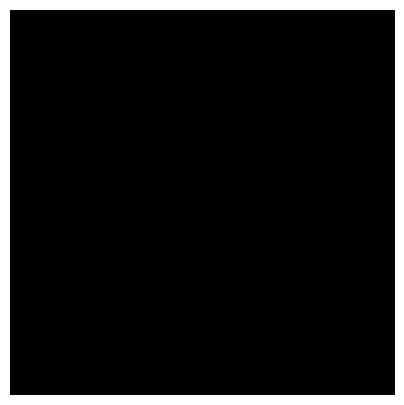

In [3]:
# the size is arbitrary the landmark locations will be rendered relative to the dimensions of the background image provided
annotated_image = np.zeros((1024,1024,3),dtype=np.uint8)
show_image(annotated_image)  # show empty blackground image for reference

In [4]:
class Landmarks(object):
    pass

def get_landmarks_from_parquet(pf,frame):
    f = pf[pf.frame == frame]
    face = landmark_pb2.NormalizedLandmarkList()
    for t in f[f.type=='face'][['x','y','z']].itertuples(index=False):
        face.landmark.add(x=t.x,y=t.y,z=t.z)
    # pose = landmark_pb2.NormalizedLandmarkList()
    pose = landmark_pb2.NormalizedLandmarkList()
    for t in f[f.type=='pose'][['x','y','z']].itertuples(index=False):
        pose.landmark.add(x=t.x,y=t.y,z=t.z)
    left_hand = landmark_pb2.NormalizedLandmarkList()
    for t in f[f.type=='left_hand'][['x','y','z']].itertuples(index=False):
        left_hand.landmark.add(x=t.x,y=t.y,z=t.z)
    right_hand = landmark_pb2.NormalizedLandmarkList()
    for t in f[f.type=='right_hand'][['x','y','z']].itertuples(index=False):
        right_hand.landmark.add(x=t.x,y=t.y,z=t.z)    
    result = Landmarks()
    result.face_landmarks = face
    result.pose_landmarks = pose
    result.left_hand_landmarks = left_hand
    result.right_hand_landmarks = right_hand
    return result
    

In [5]:
landmarks = get_landmarks_from_parquet(pf,200)
# show_image(draw_landmarks(landmarks,annotated_image))

In [10]:
path = "./asl-kaggle/by_labels/alligator/1145220890.parquet"
pf = pd.read_parquet(path)
pf.head()

,frame,row_id,type,landmark_index,x,y,z
0,0,0-face-0,face,0,0.480886,0.546504,-0.033472
1,0,0-face-1,face,1,0.481366,0.521996,-0.063917
2,0,0-face-2,face,2,0.480800,0.531214,-0.033660
3,0,0-face-3,face,3,0.464800,0.493294,-0.048633
4,0,0-face-4,face,4,0.480110,0.512801,-0.067883


In [61]:
frames = pf.frame.unique()  # get the frames from the parquet file
annotated_image = np.zeros((1024,1024,3),dtype=np.uint8)

def show_frame(frame):
    landmarks = get_landmarks_from_parquet(pf,frames[frame])
    show_image(draw_landmarks(landmarks,annotated_image),figsize=(9,9),title=f'frame: {frames[frame]} [{frame+1} of {len(frames)}]')
    #print(f'showing frame: {frames[frame]}')
    
i = interact(show_frame,frame=widgets.IntSlider(min=0, max=len(frames)-1, step=1, value=0))

interactive(children=(IntSlider(value=0, description='frame', max=4), Output()), _dom_classes=('widget-interac…

In [17]:
path = "./asl-kaggle/averaged_by_labels/alligator/106350080.parquet"
pf = pd.read_parquet(path)
pf.head()

,frame,row_id,type,landmark_index,x,y,z
0,23,23-face-0,face,0,0.463892,0.554760,-0.036043
1,23,23-face-1,face,1,0.458248,0.532822,-0.054512
2,23,23-face-2,face,2,0.461142,0.545316,-0.033657
3,23,23-face-3,face,3,0.449503,0.503598,-0.032743
4,23,23-face-4,face,4,0.458119,0.523112,-0.055743


In [21]:
frames = pf.frame.unique()  # get the frames from the parquet file
annotated_image = np.zeros((1024,1024,3),dtype=np.uint8)

def show_frame(frame):
    landmarks = get_landmarks_from_parquet(pf,frames[frame])
    show_image(draw_landmarks(landmarks,annotated_image),figsize=(9,9),title=f'frame: {frames[frame]} [{frame+1} of {len(frames)}]')
    #print(f'showing frame: {frames[frame]}')
    
i = interact(show_frame,frame=widgets.IntSlider(min=0, max=len(frames)-1, step=1, value=0))

interactive(children=(IntSlider(value=0, description='frame', max=24), Output()), _dom_classes=('widget-intera…